<p align="center">
  <img align="right" src="https://nilearn.github.io/dev-days-2020/assets/images/nilearn-logo.png" alt="image" width="250" />
</p>

<h1 align="center">MultiRat Sensory-Evoked analysis code</h1>

<p align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Marie E Galteau, 2023</i></p>

---

## First Level Analysis - **Rat** Hemodynamic Response Function (HRF)

The present jupyter notebook contains the code to reproduce the first level analysis with custimized rat's hemodynamic response functions (HRF): 

- ** Two_gammas, aka Two_gammas** --> Lambers, H. et al. (2020). A cortical rat hemodynamic response function for improved detection of BOLD activation under common experimental conditions. NeuroImage, 208, 116446. https://doi.org/10.1016/j.neuroimage.2019.116446

- **Peak_span** --> Silva, A. C., et al. (2007). Functional MRI impulse response for BOLD and CBV contrast in rat somatosensory cortex. Magnetic resonance in medicine, 57(6), 1110–1118. https://doi.org/10.1002/mrm.21246

Follow the code step-wise. 


In [12]:
# --- Imports ---
import nilearn 
import pandas as pd
import numpy as np 
import nibabel as nib
import glob
import os
import matplotlib.pyplot as plt

from numpy import savetxt
from scipy.stats import gamma
from nilearn import plotting, image
from nilearn.plotting import plot_design_matrix
from IPython.display import Markdown, display
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix

In [5]:
# --- Init variables --- 
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'

# --- Data path ---
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
mask = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'

### Let's define the first rat function: Two_gammas
We implemented the generic rat HRF from Lambers et al., following the MATLAB code (Supplementary material C)

>"The generic rat HRF was specified for measurements with 5 s or longer stimulation duration."

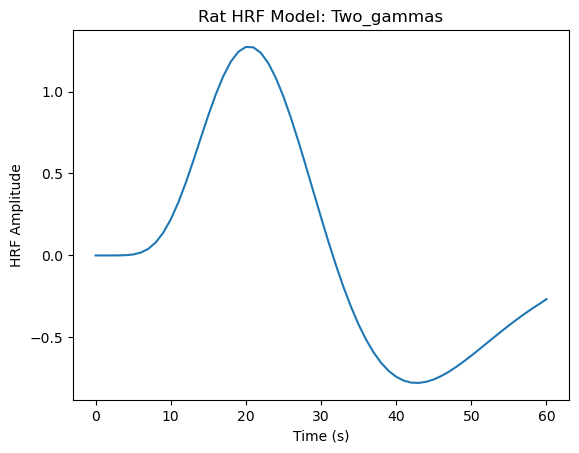

In [15]:
# --- Define Two_gammas --- 

"""
Implement the rat response function model

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Parameters gamma func
    ---------------------
    time_length : stimulation duration in seconds, must be defined before running the function
    tr : in seconds
    h1, h2, l1, and l2 : define the shape and scale parameters
    V = ratio parameter 
    
    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid

""" 

np.printoptions(False)

def Two_gammas(tr, oversampling=16, onset=0.0 ):
    dt = tr / oversampling
    #time_length = duration + onset
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset
     
    # Parameters of the gamma function
    h1 = 3.7
    h2 = 4.45
    l1 = 0.5
    l2 = 0.5
    V = 1.5

    response_function = (gamma.pdf(time_stamps, h1 / l1, scale=1 / l1) -
                         gamma.pdf(time_stamps, h2 / l2, scale=1 / l2)) / V
    
    response_function /= response_function.sum()
    response_function *= 1
   
    return response_function


# --- Plot the function with example values ---

time_length = 30
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

signal, _labels = compute_regressor(exp_condition=exp_condition,
                                    hrf_model=Two_gammas,
                                    frame_times=frame_times)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF Model: Two_gammas')
plt.show()

### And the second rat function: Peak_span
We defined the function by a full width at half maximum of 2.18 and a time to peak of 1.92, as described by Silva et al.


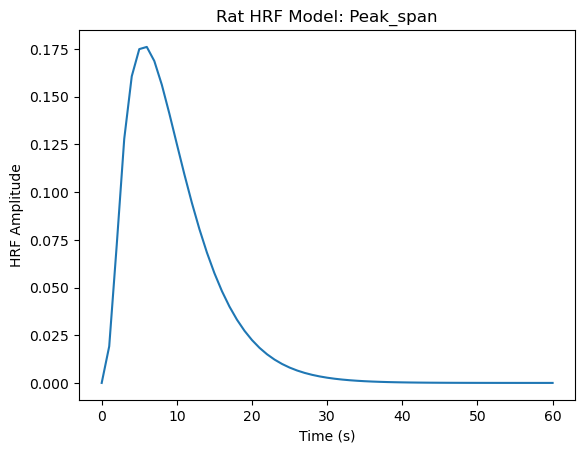

In [16]:
# --- Define Peak_span --- 

"""
Implement the rat response function model.

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid
"""

def Peak_span(tr, oversampling=16, onset=0.0):
    
    dt = tr / oversampling
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset

    # parameters of the gamma function
    delay = 2.18
    dispersion = 1.92

    response_function = gamma.pdf(time_stamps, delay, loc=0, scale=dispersion)
    response_function /= response_function.sum()

    return response_function


# --- Plot the function with example values ---

time_length = 30
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

signal, _labels = compute_regressor(exp_condition=exp_condition,
                                    hrf_model=Peak_span,
                                    frame_times=frame_times)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF Model: Peak_span')
plt.show()

**Select the hemodynamic response function!**

In [17]:
# --- Select HRF model ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    Two-gammas
    Peak_span
"""

#hrf_function = Two-gammas
hrf_function = Peak_span
print('The chosen HRF model is:', hrf_function)

The chosen HRF model is: <function Peak_span at 0x7f0fe6c8d0d0>


Almost there... 

**Define output directories.**
This is based on the HRF selected right above.

In [18]:
# --- Output directories ---
output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/'
subdirectories = ['Two-gammas', 'Peak_span']

base_dir = os.path.join(output_dir, 'Two_gammas') if hrf_function == Two_gammas else os.path.join(output_dir, 'Peak_span')
matrix_dir = os.path.join(base_dir, 'matrix/')
image_dir = os.path.join(base_dir, 'image/')
model_dir = os.path.join(base_dir, 'model/')
beta_dir = os.path.join(base_dir, 'beta_estimates/')
residuals_dir = os.path.join(base_dir, 'residuals/')
effect_var_dir = os.path.join(base_dir, 'effect_var/')
predic_timeseries_dir = os.path.join(base_dir, 'predicted_timeseries/')
z_score_dir = os.path.join(base_dir, 'z_score/')

for subdir in subdirectories:
    sub_dir = os.path.join(output_dir, subdir)
    sub_dir_structure = ['matrix', 'image', 'model', 'beta_estimates', 'residuals', 'effect_var', 'predicted_timeseries', 'z_score']
    
    for sub_subdir in sub_dir_structure:
        dir_path = os.path.join(sub_dir, sub_subdir)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

    
# --- Load metadata ---    
df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

### Final steps!
1. Import the metadata file, whith the subject number, TR, timings, and other parameters are required for the analysis.
2. Define variables.
3. Compute the even regressors, basically the stimulation protocol.
4. Compute the motion regressors, output by RABIES preprocess pipeline in the cofounders.
5. Compute the design matrix and the first level model
6. Compute the contrast and plot the statistical maps
7. Save ouputs in specific directories

The chosen HRF model is: <function Peak_span at 0x7f0fe6c8d0d0>
index: 1
subj: 200101
ses: 1
TR: 2
n stim: 3
stim duration: 20


MemoryError: 

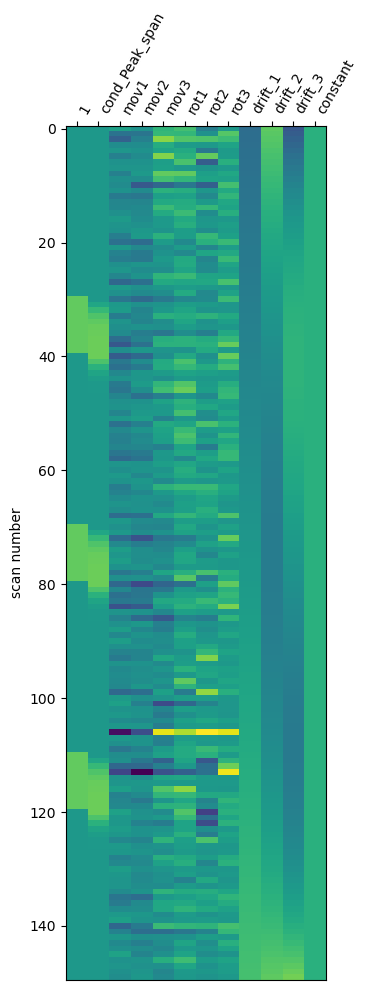

In [20]:
# ---------- FIRST LEVEL ANALYSIS ------------
# ---------------- Rat HRF -------------------

print('The chosen HRF model is:', hrf_function)

for index in range(0, 1):

    # --- Define variables --- 

    subj_num=str(df.iloc[index]['rat.sub'])   #[:-2]
    ses=str(df.iloc[index]['rat.ses'])
    print('index:', index)
    print('subj:', subj_num)
    print('ses:', ses)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-{}/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, ses))[0]
    func_img = nib.load(subject_path) 
    
    tr = int(df.iloc[index]['func.TR']) 
    #tr = 1.5
    n_scans = func_img.shape[3]   
    frame_times = np.arange(n_scans) * tr 

    # --- Events regressor --- 
    
    n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))   #count number of stimulation, number of onset

    onset_metadata = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]  # Get onsets from metadata file
    onsets = onset_metadata 

    durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    trial_type = np.ones_like(onsets)
    events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
    
    print('TR:', tr)
    print('n stim:', n_tr)
        
    
    # --- Rat HRF regressor --- 
    
    exp_condition = np.array((onsets, durations, trial_type))
    time_length = int(df.iloc[index]['func.sensory.duration'].split(',')[0].strip())

    print('stim duration:', time_length)
    
    rat_hrf_model, _labels_hrf = compute_regressor(exp_condition, hrf_function, frame_times)
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-{}/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num, ses))[0]

    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    all_regressors = np.column_stack((rat_hrf_model, motion))
    all_reg_names = _labels_hrf + motion_names

    # --- Compute design matrix --- 
    
    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=all_regressors,
                                                   add_reg_names=all_reg_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=None,
                                                   high_pass=0.01)
    
 
    plot_design_matrix(design_matrix) 
    
    # --- Fitting a first-level model ----  
    
    fmri_glm = FirstLevelModel(t_r=tr,
                                drift_model='polynomial',
                                signal_scaling=False,
                                smoothing_fwhm=0.45,
                                minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
    
    # --- Compute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
    
    # --- Plot and save as nifti file ---
    
    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                        bg_img = template_path, 
                                        threshold = 1.9, 
                                        title = 'Rat {}'.format(subj_num))
    
    # --- Save outputs ---  
    
    savetxt(matrix_dir+f'matrix_sub-0{subj_num}_ses-{ses}.csv', design_matrix, delimiter=',')
    nib.save(residuals, residuals_dir+f'residuals_sub-0{subj_num}_ses-{ses}.nii.gz')                                 #save this to nifti
    nib.save(predicted_timeseries, predic_timeseries_dir+f'predicted_timeseries_sub-0{subj_num}_ses-{ses}.nii.gz')  
    nib.save(statistical_map['z_score'], z_score_dir+f'z_score_sub-0{subj_num}_ses-{ses}.nii.gz')                    #save z map
    nib.save(statistical_map['effect_size'], beta_dir+f'beta_sub-0{subj_num}_ses-{ses}.nii.gz')                      #save the betaestimates
    nib.save(statistical_map['effect_variance'], effect_var_dir+f'effect_var_sub-0{subj_num}_ses-{ses}.nii.gz')      #save the betaestimates
    plt.savefig(image_dir+f'stat_map_sub-0{subj_num}_ses-{ses}.png')        


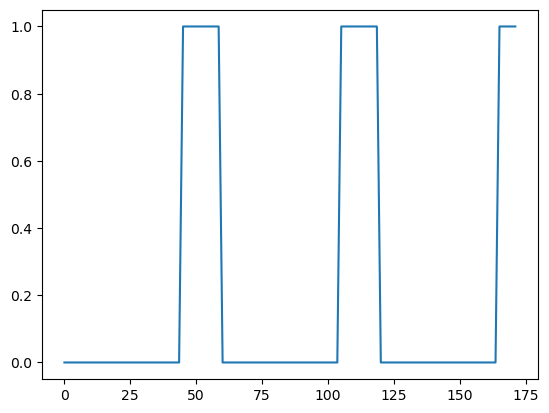

In [12]:
# --- Save model ---
rm_design_matrix = design_matrix.drop(1.0, axis=1)   # remove first column which is the block design
model = rm_design_matrix.iloc[:, 0]

plt.plot(design_matrix.iloc[:,0])
#savetxt(model_dir+'model_sub-0{}_ses-1.csv'.format(subj_num), model, delimiter=',')

In [18]:
print(events)
print(exp_condition)

   trial_type  onset  duration
0           1     52        30
1           1    142        30
2           1    232        30
3           1    322        30
4           1    412        30
5           1    502        30
6           1    592        30
7           1    682        30
8           1    772        30
9           1    862        30
[[ 52 142 232 322 412 502 592 682 772 862]
 [ 30  30  30  30  30  30  30  30  30  30]
 [  1   1   1   1   1   1   1   1   1   1]]
